# Background: LSTM networks

Long Short-Term Memory networks are one type of **Recurrent Neural Network (RNN)**. 
They are networks whose output depends on the previous ones. This loop behaviour makes them the perfect option to work with sequences and lists. 

If you want to know more about this type of netwrks read [this amazing post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) 

As we can see in [this very famous post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) , a recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor.


![RNN vs DNN t](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)




The problem comes when they have to deal with **long-term dependencies**. Although, teorically, they would be able to handle this dependencies, some researchers have found some pretty fundamental reasons why it might be difficult. LSTM are a special kind of RNN, capable of learning long-term dependencies. Actually, they are designed to remember information for long periods


Source: https://rb.gy/4ysgw5

## **Section One:** Libraries

The most important part of working with neural networks or just any ML libraries is to ensure that the libraries mesh together well.

**The 5 Essential Libraries 👌**

```
pip install keras
pip install pandas
pip install numpy
pip install re
pip install nltk
```



Depending if you are on macOS or Windows, libraries can get problematic, that's why I specifically chose to use Google Colab

```
import pandas as pd
import numpy as np
import re
import sys
import nltk
nltk.download('punkt')


from nltk import word_tokenize

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.models import model_from_json
from keras.layers import Input, Activation, Dense, Dropout
from keras.layers import LSTM, Bidirectional
```

Download the dwightTotal quotes text document

https://drive.google.com/file/d/1og_rt9Mr22xZCNTQubdUFX_ao-foqUzm/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import re
import sys
import nltk
nltk.download('punkt')
 
 
from nltk import word_tokenize
 
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.models import model_from_json
from keras.layers import Input, Activation, Dense, Dropout
from keras.layers import LSTM, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Section Two :** Formatting

The below code has three main purposes


*   Access Dwight Schrute quotes for processing
*   Convert the text file called dwightTotal.txt into somewhat of a formatted csv file type
*   Measure the length of each quote and assign a value for each quote




In [ ]:
quotes_csv = pd.read_csv('dwightTotal.txt', delimiter = '\t', header=None, error_bad_lines=False)
quotes_csv = quotes_csv.rename(columns={0: 'quote', 1:'quote_author', 2:'associative_tags'})
quotes_csv['quote_length'] = quotes_csv.quote.map(lambda x: len(x))

HERE COMES THE FUN PART!! 

So here we are going to remove all the characters that are unnecesary to the generation of quotes, the "special" ones 😂

We want to make sure that there is ZERO 0 interference in the generation of the quotes and that all of are quotes are clean hence:

```
cleaned_quotes = []
```


In [ ]:
quotes = list(quotes_csv.quote + '\n')

removed_char = ['#', '$', '%', '(', ')', '=', ';', ':', '*', '+', '£', '—', '’']
cleaned_quotes = []
sentences = []
next_chars = []

### How do we actually remove the characters and white space in our txt file?


Step One: Index through all of our quotes
```
for quote in quotes:
```
Step Two: Remove all of the forbidden characters 🚫 
```
  for s_char in removed_char:
        quote = quote.replace(s_char, ' ')
```
Step Three: Remove White Space and Add all Quotes to the cleaned_quotes list


```
  pattern = re.compile(r'\s{2,}')
  quote = re.sub(pattern, ' ', quote)

  cleaned_quotes.append(quote)

text = ' '.join(cleaned_quotes)
chars = sorted(list(set(text)))
```



In [ ]:
for quote in quotes:
    for s_char in removed_char:
        quote = quote.replace(s_char, ' ')

    pattern = re.compile(r'\s{2,}')
    quote = re.sub(pattern, ' ', quote)

    cleaned_quotes.append(quote)

text = ' '.join(cleaned_quotes)
chars = sorted(list(set(text)))

####Why are these two lines of code so important??

```
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
```

These lines allow us to assign a specific value to every character and subsequently word in our text file. It allows to be able to easily call on words through a numerical representation

Visualization

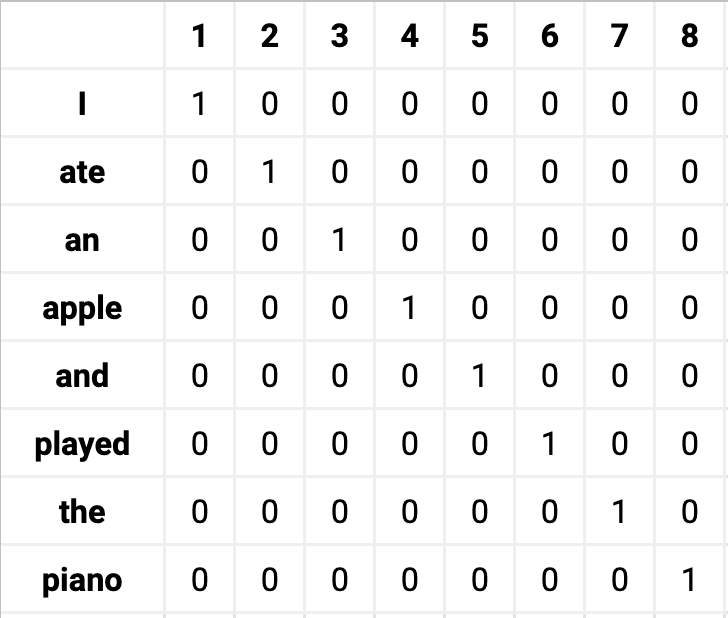



In [ ]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maximum_quote_length = 15
step = 6

for quote in cleaned_quotes:
    for i in range(0, len(quote) - maximum_quote_length, step):
        sentences.append(quote[i: i + maximum_quote_length])
        next_chars.append(quote[i + maximum_quote_length])
    sentences.append(quote[-maximum_quote_length:])
    next_chars.append(quote[-1])
print('nb sequences:', len(sentences))

print('Vectorization Process...')

x = np.zeros((len(sentences), maximum_quote_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

nb sequences: 63583
Vectorization...


#**Section Three:** Model Building and Results

In [ ]:
## Model
print('Build model...')
input_sequences = Input((maximum_quote_length, len(chars)) , name="input_sequences")
lstm = Bidirectional(LSTM(256, return_sequences= True, input_shape=(maximum_quote_length, len(chars))), name = 'bidirectional')(input_sequences)
lstm = Dropout(0.1, name = 'dropout_bidirectional_lstm')(lstm)
lstm = LSTM(64, input_shape=(maximum_quote_length, len(chars)), name = 'lstm')(lstm)
lstm = Dropout(0.1,  name = 'drop_out_lstm')(lstm)

dense = Dense(15 * len(chars), name = 'first_dense')(lstm)
dense = Dropout(0.1,  name = 'drop_out_first_dense')(dense)
dense = Dense(5 * len(chars), name = 'second_dense')(dense)
dense = Dropout(0.1,  name = 'drop_out_second_dense')(dense)
dense = Dense(len(chars), name = 'last_dense')(dense)

next_char = Activation('softmax', name = 'activation')(dense)

model = Model([input_sequences], next_char)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Build model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_sequences (InputLayer) [(None, 15, 84)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 512)           698368    
_________________________________________________________________
dropout_bidirectional_lstm ( (None, 15, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                147712    
_________________________________________________________________
drop_out_lstm (Dropout)      (None, 64)                0         
_________________________________________________________________
first_dense (Dense)          (None, 1260)              81900     
_________________________________________________________________
drop_out_first_dense (Dropou (None, 1260)     

Training the model for 125 Epochs...

Please adjust the runtime type to TPU to optimize speed, and trainign can vary between 125 to even up to 300 epochs based on how you manipulate the model


In [ ]:
model.fit([x], y,
         batch_size=2048,
          epochs= 125
         )

two_first_words = [bigram for bigram in [' '.join(word_tokenize(quote)[:2]) for quote in quotes] if
                   len(bigram) <= maximum_quote_length]


In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)



def generate_OG_quote(sentence=None, diversity=0.8):
    if not sentence: 
        random_index = np.random.randint(0, len(two_first_words))
        sentence = two_first_words[random_index]

    if len(sentence) > maximum_quote_length:
        sentence = sentence[-maximum_quote_length:]
    elif len(sentence) < maximum_quote_length:
        sentence = ' ' * (maximum_quote_length - len(sentence)) + sentence

    generated = ''
    generated += sentence
    sys.stdout.write(generated)

    next_char = 'Empty'
    total_word = 0

    max_word = 15

    while ((next_char not in ['\n', '.']) & (total_word <= 500)):

        x_pred = np.zeros((1, maximum_quote_length, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        if next_char == ' ':
            total_word += 1
        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Finally!! GENERATE YOUR QUOTE 😁😁



In [ ]:
generate_OG_quote()